## TEAM NAME: QUANTUM ENTANGLERS

### Team Members

**Rajana Rama Satya Sai Durga Prasad**  
**Enrollment ID:** WQ24-UkA0PEQyOfbIQTn  
**Email:** rajanasatyasai@gmail.com

**Sunita**  
**Enrollment ID:** WQ24-kntLxdjlEEqKqC9  
**Email:** khothsunita1508@gmail.com

### Project: QML-for-Conspicuity-Detection-in-Production


## Task 3 - Quanvolutional Neural Network

The matplotlib inline command in Jupyter Notebooks allows Matplotlib plots to be displayed directly beneath the code cells that generate them.

In [1]:
%matplotlib inline

### Imports - Pennylane used for Quantum Machine Learning and Tensor Flow

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

### Setting of the main hyper-parameters of the model


### Code Explanation

1. **Hyperparameters and Dataset Sizes**:
   - `n_epochs`: Number of training epochs.
   - `n_layers`: Number of random layers in the model.
   - `n_train`: Size of the training dataset.
   - `n_test`: Size of the test dataset.

2. **Data Saving Path**:
   - `SAVE_PATH`: Directory for saving data.
   - Creates the directory if it doesn't exist.

3. **Preprocessing Flag and Random Seeds**:
   - `PREPROCESS`: Flag to determine whether to preprocess data or load from `SAVE_PATH`.
   - Sets seeds for NumPy and TensorFlow random number generators for reproducibility.

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/"  # Data saving folder
if os.path.exists(SAVE_PATH) == False:
    os.makedirs(SAVE_PATH)

PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

### Loading of the MNIST dataset


MNIST dataset: This is a dataset of 28x28 grayscale images of the 10 digits.

We import the MNIST dataset from *Keras*.


### Code Explanation

1. **Loading the MNIST Dataset**:
   - Loads the MNIST dataset of handwritten digit images and labels.

2. **Reducing Dataset Size**:
   - Limits the training and test datasets to `n_train` and `n_test` samples, respectively.

3. **Normalizing Pixel Values**:
   - Scales pixel values to the range 0 to 1.

4. **Adding Extra Dimension for Convolution Channels**:
   - Adds an extra dimension to the images for convolutional channels, necessary for CNNs.


In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

### Quantum circuit as a convolution kernel

We initialize a PennyLane `default.qubit` device, simulating a system of
$4$ qubits. The associated `qnode` represents the quantum circuit
consisting of:

1.  an embedding layer of local $R_y$ rotations (with angles scaled by a
    factor of $\pi$);
2.  a random circuit of `n_layers`;
3.  a final measurement in the computational basis, estimating $4$
    expectation values.


### Code Explanation

1. **Device Initialization**:
   - Initializes a quantum device with 4 qubits using PennyLane's default qubit simulator.

2. **Random Circuit Parameters**:
   - Generates random parameters for the quantum circuit, uniformly distributed between 0 and \(2\pi\).

3. **Quantum Node (QNode) Definition**:
   - Defines a QNode named `circuit` to run on the initialized device.

4. **Encoding Classical Input Values**:
   - Encodes 4 classical input values into the quantum circuit using `RY` rotation gates on each qubit.

5. **Random Quantum Circuit**:
   - Applies a random quantum circuit to the 4 qubits using the generated parameters.

6. **Measurement**:
   - Measures the expectation value of the Pauli-Z operator on each qubit, returning 4 classical output values.


In [5]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

### The convolution scheme:

1.  the image is divided into squares of $2 \times 2$ pixels;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of
    a single output pixel.


This process halves the resolution of the input image. In the standard
language of CNN, this would correspond to a convolution with a
$2 \times 2$ *kernel* and a *stride* equal to $2$.


### Code Explanation

1. **Function Definition**:
   - Defines the `quanv` function to apply quantum convolution to an input image.

2. **Output Initialization**:
   - Initializes an output array `out` with zeros, shaped `(14, 14, 4)`.

3. **Loop Over Image Regions**:
   - Iterates over 2x2 regions of the 28x28 input image.

4. **Quantum Circuit Processing**:
   - Processes each 2x2 region with a quantum circuit using the `circuit` function.

5. **Assigning Quantum Circuit Results**:
   - Stores the quantum circuit's output in the corresponding channels of the output array.

6. **Return Output**:
   - Returns the convolved image stored in `out`.


In [6]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Quantum pre-processing of the dataset

Since we’re not training the quantum convolution layer, we’ll use it as a pre-processing step for all images. 
A classical model will then be trained and tested on this processed data, avoiding redundant quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.


### Code Explanation

1. **Conditional Preprocessing**:
   - Checks if `PREPROCESS` is `True` to determine if quantum preprocessing should be performed.

2. **Quantum Preprocessing of Training Images**:
   - Initializes an empty list for preprocessed training images.
   - Applies the `quanv` function to each training image and stores the results.
   - Converts the list to a NumPy array.

3. **Quantum Preprocessing of Test Images**:
   - Initializes an empty list for preprocessed test images.
   - Applies the `quanv` function to each test image and stores the results.
   - Converts the list to a NumPy array.

4. **Saving Preprocessed Images**:
   - Saves the preprocessed training and test images to `.npy` files.

5. **Loading Preprocessed Images**:
   - Loads the preprocessed images from the saved `.npy` files.


In [7]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


Let us visualize the effect of the quantum convolution layer on a batch
of samples:


### Code Explanation

1. **Setting Up the Plot**:
   - Defines the number of samples (`n_samples`) and output channels (`n_channels`).
   - Creates a grid of subplots with `1 + n_channels` rows and `n_samples` columns.

2. **Plotting Input Images**:
   - Displays the input images in the first row of subplots.
   - Sets the y-axis label to "Input" and hides the y-axis for all columns except the first one.

3. **Plotting Output Channels**:
   - Displays the output images for each channel in the corresponding rows of subplots.
   - Sets the y-axis label for each row to "Output [ch. c]" and hides the y-axis for all columns except the first one.

4. **Adjusting Layout and Displaying the Plot**:
   - Adjusts the layout to prevent overlapping of subplots.
   - Displays the plot.


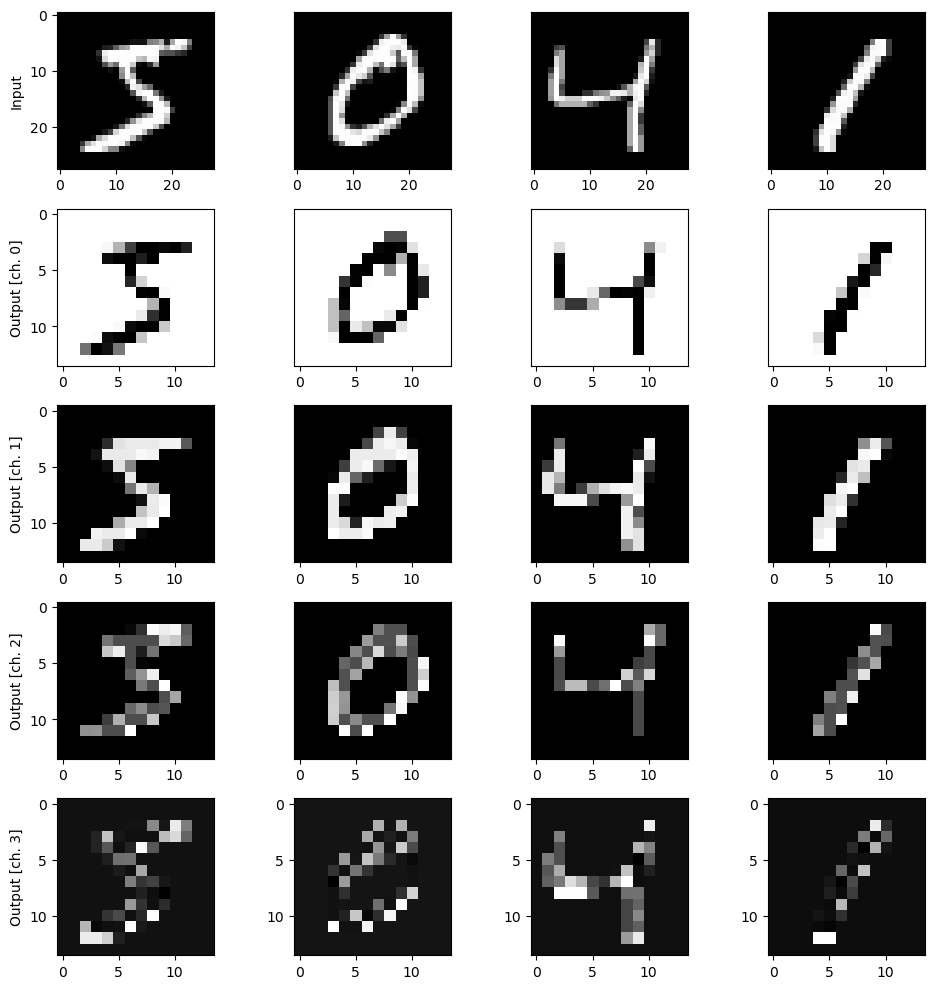

In [8]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

The $4$ output channels produced by the quantum convolution are visualized in grayscale beneath each input image.

Each input image is displayed alongside the corresponding output images for the $4$ channels generated by the quantum convolution. Although the overall shape of the images is maintained, some local distortions are visible, which is an anticipated outcome of using the quantum kernel.

### Hybrid quantum-classical model

After the application of the quantum convolution layer we feed the
resulting features into a classical neural network that will be trained
to classify the $10$ different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output
nodes with a final *softmax* activation function.

The model is compiled with a *stochastic-gradient-descent* optimizer,
and a *cross-entropy* loss function.


### Code Explanation

1. **Function Definition**:
   - Defines the `MyModel` function to initialize and return a custom Keras model.

2. **Model Initialization**:
   - Creates a Sequential model.
   - Adds a `Flatten` layer to convert input data to a 1D array.
   - Adds a `Dense` layer with 10 units and a `softmax` activation function for classification.

3. **Model Compilation**:
   - Compiles the model with the Adam optimizer.
   - Uses sparse categorical cross-entropy as the loss function.
   - Tracks accuracy as a performance metric.

4. **Return Statement**:
   - Returns the compiled model, ready for training.


In [9]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training

We initialize an instance of the model, to train it and validate it with the dataset that has been already pre-processed by a quantum convolution.

### Code Explanation

1. **Model Initialization**:
   - Initializes the custom Keras model by calling the `MyModel` function.

2. **Model Training**:
   - Trains the model using the `fit` method with the following parameters:
     - `q_train_images`: Preprocessed training images.
     - `train_labels`: Labels for the training images.
     - `validation_data`: Preprocessed test images and their labels.
     - `batch_size=4`: Number of samples per gradient update.
     - `epochs=n_epochs`: Number of training epochs.
     - `verbose=2`: Verbosity mode for detailed output.

3. **Training History**:
   - The `fit` method returns a `History` object containing training metrics.


In [10]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 72ms/step - accuracy: 0.1600 - loss: 2.7760 - val_accuracy: 0.1333 - val_loss: 2.2550
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.3000 - loss: 2.0465 - val_accuracy: 0.2000 - val_loss: 2.1336
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.4600 - loss: 1.6969 - val_accuracy: 0.4333 - val_loss: 1.9449
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.7200 - loss: 1.3929 - val_accuracy: 0.4667 - val_loss: 1.7918
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.7800 - loss: 1.1553 - val_accuracy: 0.5333 - val_loss: 1.6822
Epoch 6/30
13/13 - 0s - 7ms/step - accuracy: 0.8400 - loss: 0.9623 - val_accuracy: 0.5333 - val_loss: 1.5921
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.8800 - loss: 0.8133 - val_accuracy: 0.6000 - val_loss: 1.5156
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9000 - loss: 0.6913 - val_accuracy: 0.6000 - val_loss: 1.4498
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.5924 - val_accuracy: 0.6333 - val_loss: 1.3959
Epoch 10/30
13/13 

In order to compare the results achievable with and without the quantum
convolution layer, we initialize also a \"classical\" instance of the
model that will be directly trained and validated with the raw MNIST
images (i.e., without quantum pre-processing).


### Code Explanation
In order to compare the results achievable with and without the quantum convolution layer, we also initialize a "classical" instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).



1. **Model Initialization**:
   - Initializes the custom Keras model by calling the `MyModel` function.

2. **Model Training**:
   - Trains the model using the `fit` method with the following parameters:
     - `train_images`: Training images.
     - `train_labels`: Labels for the training images.
     - `validation_data`: Test images and their labels.
     - `batch_size=4`: Number of samples per gradient update.
     - `epochs=n_epochs`: Number of training epochs.
     - `verbose=2`: Verbosity mode for detailed output.

3. **Training History**:
   - The `fit` method returns a `History` object containing training metrics.


In [11]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 47ms/step - accuracy: 0.1600 - loss: 2.3085 - val_accuracy: 0.2000 - val_loss: 2.0828
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.3400 - loss: 1.9133 - val_accuracy: 0.3333 - val_loss: 1.9393
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.5600 - loss: 1.6315 - val_accuracy: 0.3667 - val_loss: 1.8077
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.8800 - loss: 1.3965 - val_accuracy: 0.5000 - val_loss: 1.6904
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.9000 - loss: 1.1999 - val_accuracy: 0.5333 - val_loss: 1.5906
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 1.0364 - val_accuracy: 0.5667 - val_loss: 1.5083
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.9008 - val_accuracy: 0.6333 - val_loss: 1.4409
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.7882 - val_accuracy: 0.6000 - val_loss: 1.3851
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9800 - loss: 0.6943 - val_accuracy: 0.6000 - val_loss: 1.3385
Epoch 10/30
13/13 

### Results

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


### Code Explanation

1. **Importing Matplotlib**:
   - Imports the `matplotlib.pyplot` module for creating plots.

2. **Setting Up the Plot**:
   - Creates a figure with two vertically arranged subplots (`fig, (ax1, ax2)`).

3. **Plotting Validation Accuracy**:
   - Plots validation accuracy for both the quantum model (`q_history`) and the classical model (`c_history`).
   - Sets labels for the y-axis ("Accuracy") and x-axis ("Epoch").
   - Adds a legend to differentiate between the models.

4. **Plotting Validation Loss**:
   - Plots validation loss for both the quantum model (`q_history`) and the classical model (`c_history`).
   - Sets labels for the y-axis ("Loss") and x-axis ("Epoch").
   - Adds a legend to differentiate between the models.

5. **Adjusting Layout and Displaying the Plot**:
   - Adjusts the layout to prevent overlapping of subplots.
   - Displays the plot.


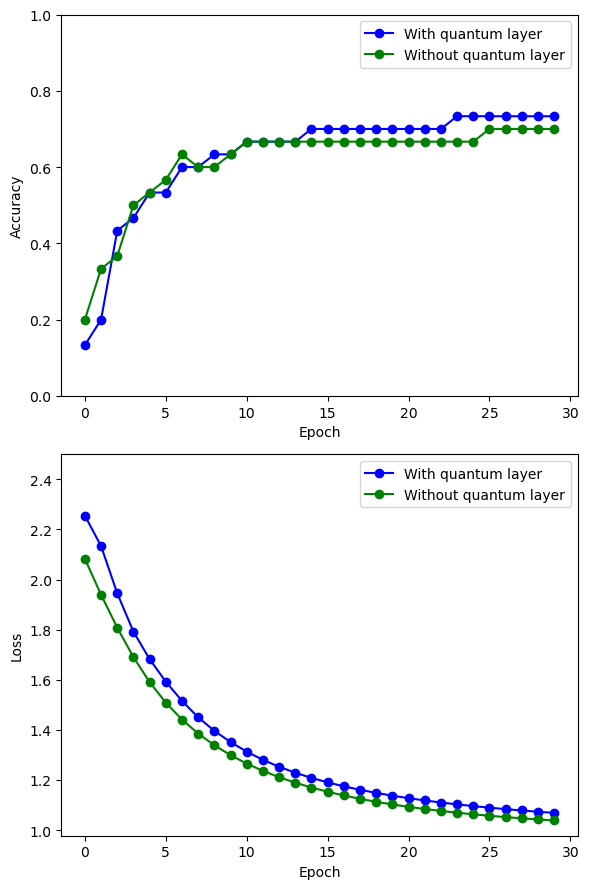

In [12]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

### References

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.
2.  Priyansh Singhal, Piyush Joshi.\"Advance Quanvolutional Layers in Quantum Classical Hybrid Neural     Networks for Image Processing./"
    DOI:10.1109/ICCAR61844.2024.10569440, 2024

### Experiments

### Code Summary

1. **Hyperparameters**:
   - `n_epochs = 5_000`: Number of optimization epochs.
   - `n_layers = 1`: Number of random layers.
   - `n_train = 50`: Size of the training dataset.
   - `n_test = 30`: Size of the test dataset.

2. **Data Saving Path**:
   - `SAVE_PATH = "quanvolution/"`: Directory for saving data.
   - Creates the directory if it doesn't exist.

3. **Preprocessing Flag**:
   - `PREPROCESS = True`: If `False`, skips quantum processing and loads data from `SAVE_PATH`.

4. **Random Seed Initialization**:
   - `np.random.seed(0)`: Sets the seed for NumPy's random number generator.
   - `tf.random.set_seed(0)`: Sets the seed for TensorFlow's random number generator.


In [13]:
n_epochs = 5_000   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/"  # Data saving folder
if os.path.exists(SAVE_PATH) == False:
    os.makedirs(SAVE_PATH)

PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

### Classical model using quantum pre-processed dataset.

### Code Summary

1. **Model Initialization**:
   - `q_model = MyModel()`: Initializes an instance of the `MyModel` class.

2. **Model Training**:
   - `q_history = q_model.fit(...)`: Trains the model with the following parameters:
     - `q_train_images`: Training dataset (input images).
     - `train_labels`: Labels for the training dataset.
     - `validation_data=(q_test_images, test_labels)`: Validation dataset and its labels.
     - `batch_size=4`: Number of samples per gradient update.
     - `epochs=n_epochs`: Number of training epochs (5,000).
     - `verbose=0`: No output during training.

3. **Training History**:
   - `q_history`: Stores the training history, including metrics like loss and accuracy for each epoch.


In [14]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

### Classical model  without quantum pre-processing.

### Code Summary

1. **Model Initialization**:
   - `c_model = MyModel()`: Initializes an instance of the `MyModel` class.

2. **Model Training**:
   - `c_history = c_model.fit(...)`: Trains the model with the following parameters:
     - `train_images`: Training dataset (input images).
     - `train_labels`: Labels for the training dataset.
     - `validation_data=(test_images, test_labels)`: Validation dataset and its labels.
     - `batch_size=4`: Number of samples per gradient update.
     - `epochs=n_epochs`: Number of training epochs (5,000).
     - `verbose=0`: No output during training.

3. **Training History**:
   - `c_history`: Stores the training history, including metrics like loss and accuracy for each epoch.


In [15]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=0,
)

### Results

### Summary of the Code Explanation

1. **Importing Library**: Imports `matplotlib.pyplot` for plotting.
2. **Plot Style**: (Commented out) Option to use "seaborn" style.
3. **Creating Subplots**: Sets up two vertical subplots with specified figure size.
4. **Plotting Accuracy**: Plots validation accuracy for models with and without a quantum layer, labels axes, sets limits, and adds a legend.
5. **Plotting Loss**: Similar to accuracy, plots validation loss, labels axes, sets limits, and adds a legend.
6. **Displaying Plot**: Adjusts layout and shows the plot.

The code compares the performance (accuracy and loss) of two models over training epochs. If you need more details, feel free to ask!


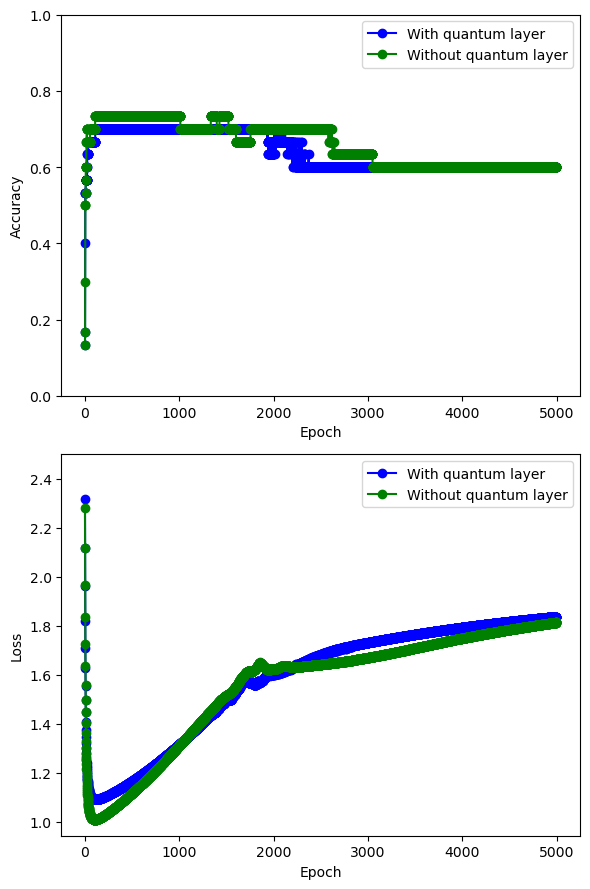

In [17]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()